## Imports

In [1]:
# If we are on colab: this clones the repo and installs the dependencies
import torch
from lightglue import LightGlue, SuperPoint, DISK
from lightglue.utils import load_image_crop, rbd, load_image, read_image
from lightglue import viz2d
from FNCs import get_key_by_value, replace_key, tensor_to_tuple, frame_exists, numpy_image_to_torch, load_data_image_crop
from AlgoFCN import FeatureTracker
from pathlib import Path

import os
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from torchvision.transforms import ToTensor
import pandas as pd
from tqdm import tqdm

import os
import glob
import copy
import numpy as np
import cv2
import time

import matplotlib.pyplot as plt
import matplotlib.patches as patches
from PIL import Image
import os
import glob
import colorsys

from IPython.display import display, Image
from IPython.display import display, clear_output
from IPython.display import Video



## Initials

In [ ]:
class LaSOTHorseDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        Args:
            root_dir (string): Directory with all the images and annotations.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        root_dir = root_dir
        self.transform = transform
        self.img_dir = os.path.join(root_dir, 'img')
        self.bbox_file = os.path.join(root_dir, 'groundtruth.txt')
        self.occlusion_file = os.path.join(root_dir, 'full_occlusion.txt')
        self.out_of_view_file = os.path.join(root_dir, 'out_of_view.txt')

        # Load annotations
        self.bboxes = pd.read_csv(self.bbox_file, header=None)
        self.occlusions = pd.read_csv(self.occlusion_file, header=None).iloc[0]
        self.out_of_views = pd.read_csv(self.out_of_view_file, header=None).iloc[0]

    def __len__(self):
        return len(self.bboxes)

    def __getitem__(self, idx):
        img_path = os.path.join(self.img_dir, f'{idx+1:08d}.jpg')
        bbox = self.bboxes.iloc[idx].values
        occlusion = self.occlusions[idx]
        out_of_view = self.out_of_views[idx]

        sample = {'image_path': img_path, 'bbox': bbox, 'occlusion': occlusion, 'out_of_view': out_of_view}

        if self.transform:
            sample = self.transform(sample)

        return sample

# Example transform that converts images to tensor
class ToTensorTransform:
    def __call__(self, sample):
        return sample

In [2]:
tracker = FeatureTracker()
# Example of using the dataset with DataLoader
horse_dataset = LaSOTHorseDataset(root_dir='/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/lasot/horse/horse-15',
                                   transform=ToTensorTransform())
# dataloader = DataLoader(horse_dataset, batch_size=1, shuffle= False)
dataloader = DataLoader(horse_dataset, batch_size=1, shuffle=False)
print(len(dataloader))

plottingFrames = []

for i, item in enumerate(dataloader):
    imagePath = item['image_path'][0]
    bbox = item['bbox'][0]
    occlusion = item['occlusion'][0]
    outOfView = item['out_of_view'][0]

    desRec = [bbox[0], bbox[1], bbox[0] + bbox[2], bbox[1] + bbox[3]]
    desRec = [x.item() for x in desRec]
    isOnline = False
    __cpTracks, __kpMvmt, image_cv2 = tracker.process_frame(imagePath, i, desRec, isOnline)
    cvFrame = tracker.update_cvFrame(__cpTracks, image_cv2, i, desRec, _isOnline = False, pltTrackLines = True)

    plottingFrames.append(cvFrame)

    # if (not occlusion) or (not outOfView): 
    #     pass

    # print(f"Item {i+1}")
    # print(imagePath, bbox, occlusion, outOfView)

    # image = read_image(imagePath).permute(1, 2, 0) / 255  # Convert the image to the [0, 1] range

    # fig, ax = plt.subplots()
    # ax.imshow(image)
    # # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2] - bbox[0], bbox[3] - bbox[1], linewidth=1, edgecolor='r', facecolor='none')
    # rect = patches.Rectangle((bbox[0], bbox[1]), bbox[2], bbox[3], linewidth=1, edgecolor='r', facecolor='none')

    # ax.add_patch(rect)
    # plt.show()

    # Break after first batch just for demonstration
    if i > 20:
        break

device =  cuda
Current device: Quadro RTX 8000
Feature Extractor is:  aliked


NameError: name 'LaSOTHorseDataset' is not defined

In [2]:
address = '/usr/mvl2/ksgh2/Documents/projects/VOT/Datasets/data/CNT_Growth_RK/exp1_gf_clahe'
files314_pathes = glob.glob(address +  '/* 314 -*.tif')


### Algorithm Functions

In [3]:
tracker = FeatureTracker(ftExtractor = 'aliked', mx_keypoints = 1024, desired_device = 3)

plottingFrames = []
gr_exp_1_314 = []


for i, imagePath in tqdm(enumerate(files314_pathes)):
    # Get the base name of the file
    basename = os.path.basename(imagePath)
    # Remove 'exp1_gf_clahe/' from the beginning of the name
    orginal_name = basename.replace('gf_clh_', '')

    if i < 0:
        gr_exp_1_314.append((orginal_name, -1))
    elif i < 10:
        idx = i - 0
        desRec = [0, 0, 1024, 450]
        isOnline = False
        __cpTracks, __kpMvmt, image_cv2, _frmTracks = tracker.process_frame(imagePath, idx, desRec, isOnline)
        # First, filter out tracks with less than 3 keypoints to avoid modifying the dictionary during iteration
        # __cpTracks = {key: value for key, value in __cpTracks.items() if len(value) >= 3}

        # # Create a dictionary that maps track IDs to colors

        cvFrame = tracker.update_cvFrame(__cpTracks, image_cv2, _frmTracks, desRec, _isOnline = False)
        plottingFrames.append(cvFrame)

        nmGrowthrate = 0
        if __kpMvmt > 0:
            nmGrowthrate = np.log(__kpMvmt * 5) # conversion to nm and log scale 400px = 2um -> 1 px = 2um/400px = 5nm/px
        gr_exp_1_314.append((orginal_name, nmGrowthrate))
    if i >= 1350:
        gr_exp_1_314.append((orginal_name, -1))
    


    

1356it [00:23, 58.22it/s]


In [4]:
fourcc = cv2.VideoWriter_fourcc(*'mp4v')  # Use 'mp4v' for .mp4 format

# Use the shape of the first image to get the frame size (width, height)
frame_size = (plottingFrames[0].shape[1], plottingFrames[0].shape[0])

# Create a VideoWriter object. Adjust FPS to your liking.
out = cv2.VideoWriter('clahe_output_video.mp4', fourcc, 1.0, frame_size)

for i in range(len(plottingFrames)):
    # Write the frame to the video
    out.write(plottingFrames[i])

# Release everything when job is finished
out.release()

# Optionally, display a message
print("The video was successfully saved!")

The video was successfully saved!


### Run the code


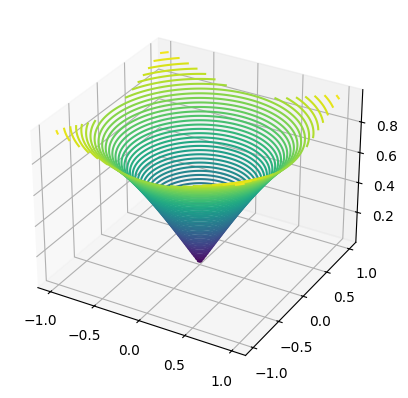

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Example: Generate some synthetic data for demonstration
# Let's assume these are your boundary features for each slice
x = np.linspace(-1, 1, 100)
y = np.linspace(-1, 1, 100)
X, Y = np.meshgrid(x, y)
Z = np.sin(np.sqrt(X**2 + Y**2))

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plotting each slice
# In a real scenario, you would loop through your slices
ax.contour3D(X, Y, Z, 50)

plt.show()